In [1]:
%cd ~/protein-transfer

/home/francesca/protein-transfer


In [2]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [68]:
from __future__ import annotations

import ast

import numpy as np
import pandas as pd

from scr.params.emb import MODEL_SIZE
from scr.params.vis import ORDERED_TASK_LIST, TASK_LEGEND_MAP

In [4]:
# the highest performing layer vs one-hot performance

In [65]:
result_df = pd.read_csv("results/summary/all_results.csv")

# Convert the string of lists to NumPy arrays
result_df["value"] = result_df["value"].apply(ast.literal_eval).apply(np.array)

result_df

,arch,task,model,ablation,ptp,metric,value
0,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,train_loss,"[9.59526940116963, 6.894266263718891, 6.377686..."
1,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,val_loss,"[11.18654191999164, 8.622644328345816, 8.33617..."
2,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_loss,"[13.582533778622887, 53.712009437112215, 74.04..."
3,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_1,"[0.9704321391244177, 0.9629028051372428, 0.962..."
4,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_2,"[0.19544242309285326, 0.3282696048440418, 0.31..."
...,...,...,...,...,...,...,...
1629,esm,annotation_scl_balanced,onehot,onehot,0.0,train_loss,[0.3524752729817441]
1630,esm,annotation_scl_balanced,onehot,onehot,0.0,val_loss,[1.373852210385459]
1631,esm,annotation_scl_balanced,onehot,onehot,0.0,test_loss,[2.0159953236579895]
1632,esm,annotation_scl_balanced,onehot,onehot,0.0,test_performance_2,[0.37402597402597404]


In [66]:

result_df["value"] = result_df["value"].apply(np.max)
result_df


,arch,task,model,ablation,ptp,metric,value
0,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,train_loss,9.595269
1,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,val_loss,11.186542
2,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_loss,142.187723
3,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_1,0.970432
4,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_2,0.452518
...,...,...,...,...,...,...,...
1629,esm,annotation_scl_balanced,onehot,onehot,0.0,train_loss,0.352475
1630,esm,annotation_scl_balanced,onehot,onehot,0.0,val_loss,1.373852
1631,esm,annotation_scl_balanced,onehot,onehot,0.0,test_loss,2.015995
1632,esm,annotation_scl_balanced,onehot,onehot,0.0,test_performance_2,0.374026


In [67]:
result_df["ablation"].unique()

array(['emb', 'rand', 'stat', 'onehot'], dtype=object)

In [ ]:
# MODEL_SIZE need to include onehot
# will be max seq * # token

In [72]:
df_perf_1 = result_df[
    (result_df["metric"] == "test_performance_1") & (result_df["arch"] == "esm")
].copy()
df_perf_1["task_type"] = df_perf_1["task"].str.split("_").str[0]
df_perf_1["model_size"] = df_perf_1["model"].map(MODEL_SIZE)

df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1078,esm,proeng_thermo_mixed_split_mean,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.991052,proeng,670.0
1083,esm,proeng_thermo_mixed_split_mean,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.990692,proeng,85.0
1088,esm,proeng_thermo_mixed_split_mean,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.991452,proeng,650.0
1093,esm,proeng_thermo_mixed_split_mean,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.990299,proeng,43.0
1098,esm,proeng_gb1_two_vs_rest_mean,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.895943,proeng,43.0
...,...,...,...,...,...,...,...,...,...
1620,esm,annotation_scl_balanced_mean,esm1b_t33_650M_UR50S,stat,0.0,test_performance_1,0.889467,annotation,650.0
1624,esm,structure_ss3_casp12,onehot,onehot,0.0,test_performance_1,0.620213,structure,NaN
1626,esm,structure_ss3_cb513,onehot,onehot,0.0,test_performance_1,0.640519,structure,NaN
1628,esm,structure_ss3_ts115,onehot,onehot,0.0,test_performance_1,0.641972,structure,NaN


In [73]:
df_perf_1["task"] = df_perf_1["task"].str.replace("_mean", "")
df_perf_1["task"] = df_perf_1["task"].str.replace("_noflatten", "")



In [74]:
df_perf_1["task"] = pd.Categorical(df_perf_1["task"], categories=ORDERED_TASK_LIST, ordered=True).map(TASK_LEGEND_MAP)
df_perf_1 = df_perf_1.sort_values("task")

df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.0
1388,esm,GB1 - sampled,esm1_t12_85M_UR50S,stat,0.0,test_performance_1,0.953893,proeng,85.0
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.0
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.0
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.0
...,...,...,...,...,...,...,...,...,...
1472,esm,SS3 - TS115,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.932380,structure,670.0
1628,esm,SS3 - TS115,onehot,onehot,0.0,test_performance_1,0.641972,structure,NaN
1524,esm,SS3 - TS115,esm1_t34_670M_UR50S,rand,0.0,test_performance_1,0.721797,structure,670.0
1576,esm,SS3 - TS115,esm1_t34_670M_UR50S,stat,0.0,test_performance_1,0.708840,structure,670.0


In [75]:
import numpy as np
import scipy.special
import pandas as pd

# Our main plotting package (must have explicit import of submodules)
import bokeh.io
import bokeh.plotting

# Enable viewing Bokeh plots in the notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [76]:
df_perf_1.ablation.unique()

array(['emb', 'stat', 'rand', 'onehot'], dtype=object)

In [77]:
df_perf_1 = df_perf_1[(df_perf_1["ablation"] == "onehot") | (df_perf_1["ablation"] == "emb")]
df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.0
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.0
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.0
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.0
1453,esm,GB1 - sampled,onehot,onehot,0.0,test_performance_1,0.934260,proeng,NaN
1448,esm,GB1 - low vs high,onehot,onehot,0.0,test_performance_1,0.917841,proeng,NaN
1133,esm,GB1 - low vs high,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.943977,proeng,43.0
1128,esm,GB1 - low vs high,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.947277,proeng,670.0
1123,esm,GB1 - low vs high,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.942702,proeng,85.0
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.957389,proeng,650.0


In [78]:
df_perf_1.task.unique()

['GB1 - sampled', 'GB1 - low vs high', 'GB1 - two vs rest', 'AAV - two vs many', 'AAV - one vs many', 'Thermostability', 'Subcellular localization', 'SS3 - CASP12', 'SS3 - CB513', 'SS3 - TS115']
Categories (10, object): ['GB1 - sampled' < 'GB1 - low vs high' < 'GB1 - two vs rest' < 'AAV - two vs many' ... 'Subcellular localization' < 'SS3 - CASP12' < 'SS3 - CB513' < 'SS3 - TS115']

In [79]:
from bokeh.palettes import brewer


In [80]:
import seaborn as sns

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [82]:
from scr.params.vis import ORDERED_TASK_LIST, ORDERED_TASK_LIST_SIMPLE, TASK_LEGEND_MAP, TASK_SIMPLE_COLOR_MAP

In [83]:
from scr.params.emb import MODEL_SIZE

In [84]:
import matplotlib as mpl

In [85]:
TASK_SIMPLE_COLOR_MAP

{'GB1 - sampled': '#6e4a2e',
 'GB1 - low vs high': '#b3703a',
 'GB1 - two vs rest': '#f79646',
 'AAV - two vs many': '#376977',
 'AAV - one vs many': '#4bacc6',
 'Thermostability': '#f9be00',
 'Subcellular localization': '#8064a2',
 'SS3 - CASP12': '#4c5835',
 'SS3 - CB513': '#748947',
 'SS3 - TS115': '#9bbb59'}

In [86]:
sliced_df[sliced_df["ablation"] == "emb"]

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.0
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.0
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.0
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.0


In [89]:
sliced_df[sliced_df["ablation"] == "onehot"]

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1453,esm,GB1 - sampled,onehot,onehot,0.0,test_performance_1,0.93426,proeng,NaN


In [91]:
np.repeat(y, len(x))


array([0.93426006, 0.93426006, 0.93426006, 0.93426006])

In [93]:
sliced_df["model_size"].values

array([ 85.,  43., 650., 670.,  nan])

In [97]:
s

array([ 79.96772262, 116.58550253, 117.13099882,          nan])

0 0.8 None


TypeError: 'module' object is not callable

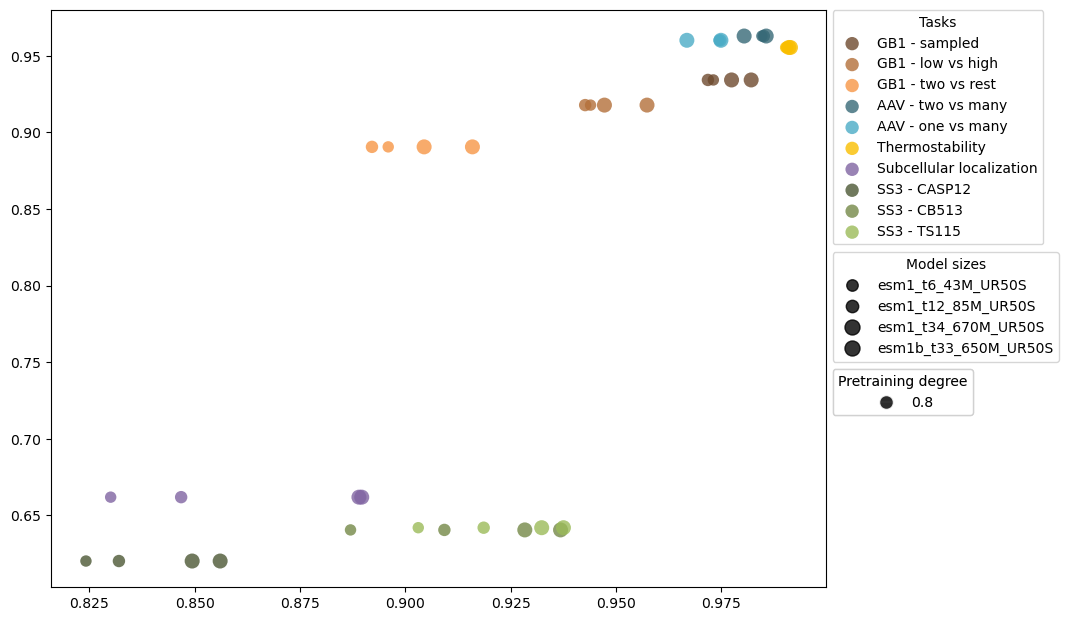

In [99]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5)

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():
    sliced_df = df_perf_1[df_perf_1["task"] == task]
    emb_df = sliced_df[sliced_df["ablation"] == "emb"]
    onehot_df = sliced_df[sliced_df["ablation"] == "onehot"]

    x = emb_df["value"].values
    # note their is only one onehot for all embeddings for each tast
    y = onehot_df["value"].values
    y = np.repeat(y, len(x))

    c = c
    # the there is one for onehot
    model_sizes = sliced_df["model_size"].values

    s = np.log(model_sizes[~np.isnan(model_sizes)]) * 18
    alpha = [0.8]
    scatter = ax.scatter(x, y, c=c, s=s, label=task, alpha=alpha, edgecolors="none")

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

handles, labels = scatter.legend_elements(prop="sizes", color="k", alpha=0.8)
legend2 = ax.legend(
    handles, list(MODEL_SIZE.keys())[:4], bbox_to_anchor=(1, 0.5925), loc="upper left", title="Model sizes"
)
ax.add_artist(legend2)

alpha_legend = [None] * len(alpha)
for i, a in enumerate(alpha):
    print(i, str(a), alpha_legend[i])
    alpha_legend[i] = Line2D([0], [0], marker='o', color='w', label=str(a), alpha=a, markerfacecolor='k', markersize=10)

ax.add_artist(ax.legend(handles=alpha_legend, bbox_to_anchor=(1, 0.39), loc="upper left", title="Pretraining degree"))

mpl.legend(alignment='left')

plt.xlabel("Best embedding performance")
plt.ylabel("Onehot")
plt.title("ESM best layer test performance against onehot baseline")

plt.show()